In [46]:
using Pkg
# environmentName will be used at different places in the notebook
environmentName = "04-regression"
Pkg.activate(joinpath(dirname(pwd()), "conf", environmentName))
Pkg.instantiate();

  Activating project at `~/Syncthing/Programmierung/MathData-SoSe22/conf/04-regression`


In [47]:
using LinearAlgebra, Plots, StatsBase
using RDatasets
using Optim

# Regression

First we are gonna load the datset `cars` from the `RDatasets` package and display the variable names.

In [48]:
data_cars = dataset("datasets", "cars");
names(data_cars)

2-element Vector{String}:
 "Speed"
 "Dist"

In [49]:
size(data_cars,1)

50

Each data point consists of speed and distance values which which indicates a linear relation as: speed is more or less distance over time. We are gonna choose a linear model:

$$f_\theta(x) =  a x + b$$

with $\theta =(a,b)\in\mathbb R^2$.

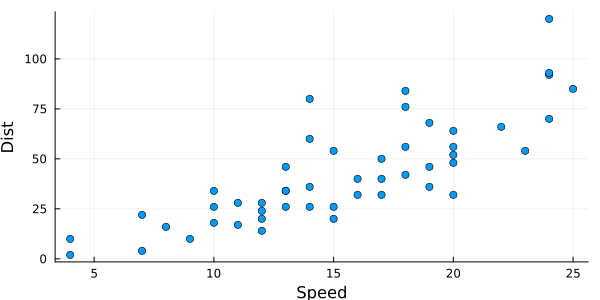

In [50]:
scatter(data_cars[:,"Speed"], data_cars[:,"Dist"], 
            legend=false, 
            xlabel = "Speed",
            ylabel = "Dist",
            size = (600,300))

We want to estimate $\theta$. Note that both speed and distance are scalars or 1-dimensional data.

In [51]:
D = 1; N = 1;

## Splitting the data

To split the data into a test and training set we randomly choose $75\%$ of the dataset as training data and the remainder as test data.

In [52]:
k = size(data_cars, 1)
n = round(Int, k * 0.75)

38

`X`is gonna contain the speed training data and `Y` the distance training data.

In [53]:
i_training = sample(1:k, n, replace = false)
X = data_cars[i_training,"Speed"]
Y = data_cars[i_training,"Dist"];

Similarly we use `X_test` and `Y_test` for the test data.

In [54]:
i_test = setdiff(1:k, i_training)
X_test = data_cars[i_test,"Speed"]
Y_test = data_cars[i_test,"Dist"];

## Model Definition

Our deterministic model is $f:\mathbb R^D \to \mathbb R^N$ or to be more clear since $D = N = 1$ and $\theta = (a, b)$ it is $f: \mathbb{R} \to \mathbb{R}, x \mapsto ax + b$ with $x$ referring to the speed and $f(x)$ referring to the distance. We choose `Number` as the datatype for $x$ since $N = 1$. We can extend the use of $f$ via [Mutiple Dispatch](https://docs.julialang.org/en/v1/manual/methods/). If $x$ is a `Number` then the first defintion of $f$ will be used. If $X$ is a `Vector` then the second defintion will be used.

In [55]:
f(x::Number, θ) = θ[2] * x + θ[1];

In [56]:
f(X::Vector, θ) = [f(x, θ) for x in X]

f (generic function with 2 methods)

In [57]:
methods(f)

# 2 methods for generic function "f" from Main:
 [1] f(X::Vector, θ)
     @ ~/Syncthing/Programmierung/MathData-SoSe22/Notebooks/jl_notebook_cell_df34fa98e69747e1a8f8a730347b8e2f_X24sZmlsZQ==.jl:1
 [2] f(x::Number, θ)
     @ ~/Syncthing/Programmierung/MathData-SoSe22/Notebooks/jl_notebook_cell_df34fa98e69747e1a8f8a730347b8e2f_X23sZmlsZQ==.jl:1

Coming back to the original problem: We also want to define the statistical model with variance $\sigma^2=10$.

In [58]:
σ² = 10
s = sqrt(σ²)
Φ(x::Number, θ) = s * randn() + f(x, θ)
Φ(X::Vector, θ) = [Φ(x, θ) for x in X];

We use the following feature matrix:

In [59]:
Ω = [ones(n) X];

---
## Training

Let's traing our model with both methods.

### Empirical Risk Minimization

ERM estimates $\theta = \Omega^\dagger Y$. We can use the builtin "solve" operation:

In [60]:
θ_ERM = Ω \ Y

2-element Vector{Float64}:
 -19.865311446896403
   4.043048157408413

ERM estimates the parameters of $f_\theta(x)=ax+b$ as such:

In [61]:
println("a = $(θ_ERM[2]), b = $(θ_ERM[1])")

We visualize the estimated function together with the training data.

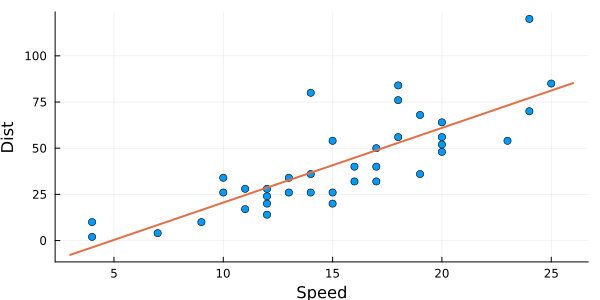

In [62]:
p = collect((minimum(X)-1):0.5:(maximum(X)+1))

scatter(X,Y, legend=false, 
            xlabel = "Speed",
            ylabel = "Dist",
            size = (600,300))
plot!(p, f(p, θ_ERM), lw = 2)

Let's also have a look at the test data.

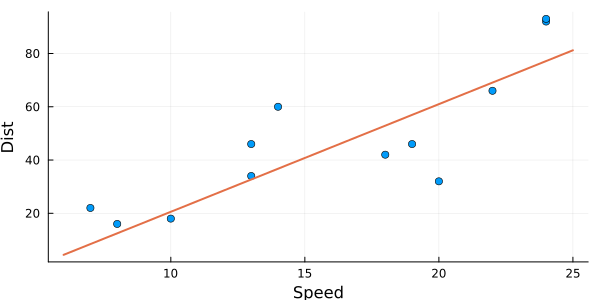

In [63]:
p = collect((minimum(X_test)-1):0.5:(maximum(X_test)+1))

scatter(X_test,Y_test, legend=false, 
            xlabel = "Speed",
            ylabel = "Dist",
            size = (600,300))
plot!(p, f(p, θ_ERM), lw = 2)

### Ridge Regression

Ridge-Regression (RR) with parameter $\lambda$ is calculated as follows.

In [64]:
θ_T(λ) = (Ω' * Ω + (n*λ) .* diagm(ones(D+1))) \ (Ω' * Y)

θ_T (generic function with 1 method)

We are gonna plot the RR-estimator for different $\lambda$ values.

┌ Info: Saved animation to MathData-SoSe22/img/04-regression/ridge_regression_1.gif
└ @ Plots /.julia/packages/Plots/Ec1L1/src/animation.jl:156


Plots.AnimatedGif("MathData-SoSe22/img/04-regression/ridge_regression_1.gif")
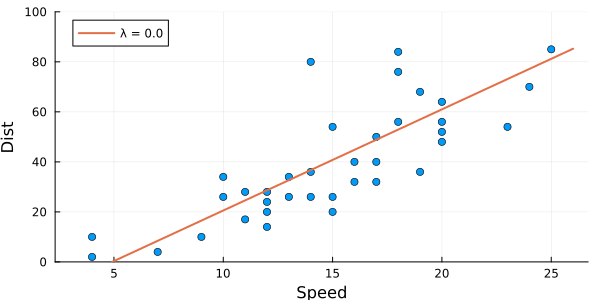

In [65]:
p = collect((minimum(X)-1):0.5:(maximum(X)+1))

anim = @animate for λ in 0:0.02:0.25
    scatter(X,Y, label=false, 
            xlabel = "Speed",
            ylabel = "Dist",
            size = (600,300))
    plot!(p, f(p, θ_T(λ)), lw = 2, label = "λ = $λ")
    ylims!(0,100)
end
gif(anim, joinpath(dirname(pwd()), "img", environmentName, "ridge_regression_1.gif"), fps = 3)

The animation suggests $\lambda=0.2$ is an appropriate value.

In [66]:
θ_RR = θ_T(0.2);

This results in the RR estimation for $f_\theta(x)=ax+b$ as:

In [67]:
println("a = $(θ_RR[2]), b = $(θ_RR[1])")

### Maximum Likelihood und Maximum a-Posteriori Estimation

The parameter of Maximum Likelihood (ML) is `θ_ERM` and the parameter of Maximum a-Posteriori Estimation (MAP) is `θ_T(λ)` with $\lambda = \sigma^2/n$.

In [68]:
θ_ML = θ_ERM
θ_MAP = θ_T(σ²/n);

We can insert these parameters into our statistical model and then sample from it.

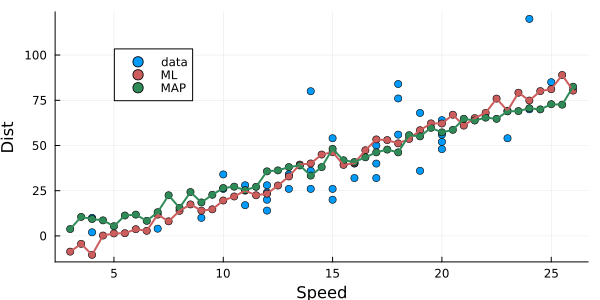

In [69]:
a1 = Φ(p, θ_ML)
a2 =  Φ(p, θ_MAP)
scatter(X,Y, label = "data", legend = (0.2,0.8),
            xlabel = "Speed",
            ylabel = "Dist",
            size = (600,300))
scatter!(p, a1, lw = 2, c = :indianred, label ="ML")
scatter!(p, a2, lw = 2, c = :seagreen, label = "MAP")
plot!(p, a1, lw = 2, c = :indianred, label = false)
plot!(p, a2, lw = 2, c = :seagreen, label = false)

### Neural Network

Next we want to estimate the relation of `Dist` und `Speed` using a neural network with ReLU activation function.

In [70]:
σ(z) = max(0,z);

We are gonna choose depth 2 with linear parts $\mathbb R^1\to \mathbb R^2$ and $\mathbb R^2\to \mathbb R^1$. This very simple neural network will be sufficient for this linear relationship and is defined as follows:
$$
    y_\theta(x) = \text{ReLU.}\left (x \begin{pmatrix}
            \theta_1 \\
            \theta_2
        \end{pmatrix} + \begin{pmatrix}
            \theta_3 \\
            \theta_4
        \end{pmatrix}
        \right ) \\
    \text{NN}_\theta(x) = z_\theta(x) = \text{ReLU} \left (
        (\theta_5, \theta_6) y(x) + \theta_7      
    \right )
$$

In [71]:
function f_NN(x::Number, θ)
    A, b = reshape(θ[1:2], 2, 1), θ[3:4]
    y = σ.(A * x + b)
    
    A, b = reshape(θ[5:6], 1, 2), θ[7:7]
    z = σ.(A * y + b)
    
    z[1]
end
f_NN(X::Vector, θ) = [f_NN(x, θ) for x in X];

Since we do not have a closed formula to calculate `θ_ERM` for the neural network we have to estimate `θ_ERM` using optimization methods. For this we use the `optimize` function from the package `Optim.jl` as a blackbox.

In [72]:
R_NN(θ, X, Y) = mean((f_NN(X, θ) - Y).^2)
o = optimize(θ -> R_NN(θ, X, Y), rand(7))
θ_NN = Optim.minimizer(o);

The neural network estimates a function that we can visualise using the training data.

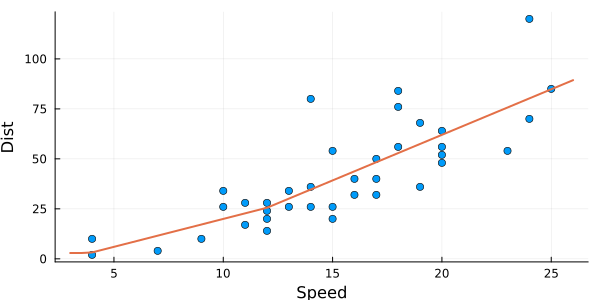

In [73]:
p = collect((minimum(X)-1):0.5:(maximum(X)+1))

scatter(X,Y, legend=false, 
            xlabel = "Speed",
            ylabel = "Dist",
            size = (600,300))
plot!(p, f_NN(p, θ_NN), lw = 2)

And similarly using the test data.

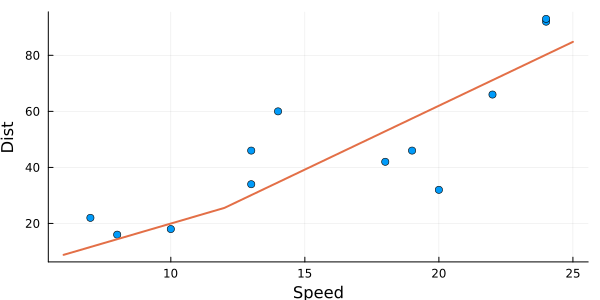

In [74]:
p = collect((minimum(X_test)-1):0.5:(maximum(X_test)+1))

scatter(X_test,Y_test, legend=false, 
            xlabel = "Speed",
            ylabel = "Dist",
            size = (600,300))
plot!(p, f_NN(p, θ_NN), lw = 2)

## Model Selection

At this point we have several models to choose from. Lets have a look at which models is most appropriate for our goal. For this we  first visually compare all models on the test data:

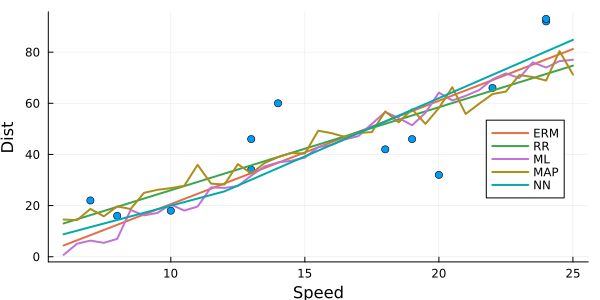

In [75]:
scatter(X_test,Y_test, legend=1,
            label = false,
            xlabel = "Speed",
            ylabel = "Dist",
            size = (600,300))
plot!(p, f(p, θ_ERM), lw = 2, label = "ERM")
plot!(p, f(p, θ_RR), lw = 2, label = "RR")
plot!(p, Φ(p, θ_ML), lw = 2, label = "ML")
plot!(p, Φ(p, θ_MAP), lw = 2, label = "MAP")
plot!(p, f_NN(p, θ_NN), lw = 2, label = "NN")

To quantify the performance of each model on the test  and training data we calculate the empirical risk.

In [76]:
R(θ, f, X, Y) = mean((f(X, θ) - Y).^2)

R (generic function with 1 method)

Which gives us

In [77]:
r = [(R(θ, f, X_test, Y_test), R(θ, f, X, Y)) for θ in [θ_ERM, θ_RR]]   
println("ERM test data risk: $(r[1][1])\n")
println("ERM train data risk: $(r[1][2])\n")
println("ERM risk ratio: $(r[1][1]/r[1][2])\n")
println("RR test data risk: $(r[2][1])\n")
println("RR train data risk: $(r[2][2])\n")
println("RR risk ratio: $(r[2][1]/r[2][2])\n")

We cannot properly distinguish the results of ERM and RR.

The neural model evaluates as such:

In [78]:
r = (R(θ_NN, f_NN, X_test, Y_test), R(θ_NN, f_NN, X, Y))
println("NN test data risk: $(r[1])\n")
println("NN train data risk: $(r[2])\n")
println("NN risk ratio: $(r[1]/r[2])\n")

---
# Regularisation

Lets have a look at a syncthetic example to see why it is important to regularise. The data will be sampled from a cubic polynomial with added noise ($n = 20$):

In [79]:
q = (x -> 1 + 4*x + 2*x^2 - 0.5*x^3)

n = 20
P = 4
X = 10 .* (rand(n) .- 0.5); # randn sampled von Unif([-5,5])
Y = map(q, X) + 5 .* randn(n);

Plotting the sampes and the cubic polynomial:

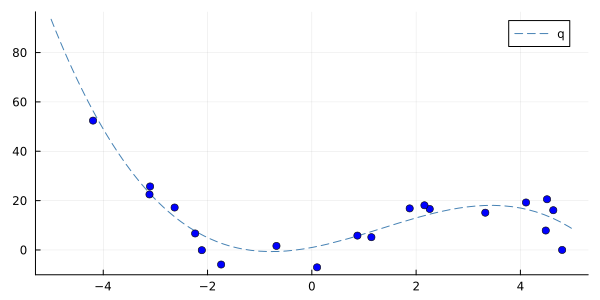

In [80]:
plot(q, label = "q", size = (600,300), linestyle = :dash, color = :steelblue)
scatter!(X,Y, label=false, color = :blue)

Now we calculate the feature matrix and the RR parameters:

In [81]:
Ω = hcat([X.^i for i in 0:P-1]...)
θ_T(λ) = (Ω' * Ω + (n*λ) .* diagm(ones(P))) \ (Ω' * Y)

θ_T (generic function with 1 method)

Each value of $\lambda$ induces a polynomial:

In [82]:
Q(λ) = (x -> sum(θ * x^(i-1) for (i,θ) in enumerate(θ_T(λ))))

Q (generic function with 1 method)

The animation suggests that regularisation ($\lambda >0$) improves the results compared to no regularisation ($\lambda =0$). 

┌ Info: Saved animation to MathData-SoSe22/img/04-regression/ridge_regression_2.gif
└ @ Plots .julia/packages/Plots/Ec1L1/src/animation.jl:156


Plots.AnimatedGif("MathData-SoSe22/img/04-regression/ridge_regression_2.gif")
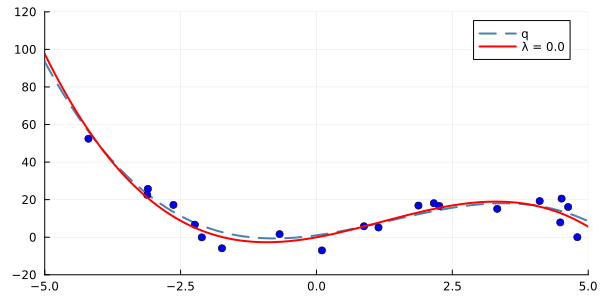

In [83]:
anim = @animate for λ in 0:10
    plot(q, label = "q", size = (600,300), linestyle = :dash, lw = 2,
        color = :steelblue, 
        xlims = (-5,5),
        ylims = (-20, 120))
    scatter!(X,Y, label=false, color = :blue)
    plot!(Q(λ/n), label = "λ = $(λ/n)", color = :red, lw = 2)
end
gif(anim, joinpath(dirname(pwd()), "img", environmentName, "ridge_regression_2.gif"), fps = 2)